In [8]:
#load pip libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skmultiflow as sci_flow
from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.evaluation import EvaluatePrequential
from datetime import datetime

#load custom libraries
from funcs.IoTDevice import IoTDevice
import funcs.json_process as json_process

In [9]:
#creating the test device and loading the json file
test_temp_device = IoTDevice()
test_json_path = "../json_file/basic_config.json"

test_temp_device.load_json(test_json_path)

#getting the value for ambient temperature calculation
ambient_temp = test_temp_device.get_device_attribute("ambientTemperature")
min_inc = test_temp_device.get_device_attribute("tag_list")["temperatureSensor1"]["states"]["run"]['minIncrease']
max_inc = test_temp_device.get_device_attribute("tag_list")["temperatureSensor1"]["states"]["run"]['maxIncrease']

#get the location for anomoly injection
anomoly_injection = test_temp_device.get_synthesis_parameter("customAnomaly")

#get the state
sensor_state = [json_process.parse_entry(entry) for entry in test_temp_device.get_synthesis_parameter("batch")]
print(sensor_state)




[('08:00', 'off'), ('09:00', 'on idle'), ('09:30', 'run'), ('09:45', 'stop idle'), ('10:00', 'run'), ('17:00', 'stop idle'), ('17:30', 'run'), ('01:30', 'stop idle'), ('02:00', 'run')]


In [ ]:

temp_range = max_inc - min_inc

# 1. Create a stream
stream = sci_flow.data.SEAGenerator(random_state=42)
stream.restart()


# 2. Get samples
n_samples = 1440
X, y = stream.next_sample(n_samples)
X = np.array(X)
feature_0 = X[:, 0] #+ mean_value
# 3. Create a time index or timestamp column
timestamps = pd.date_range(start="2023-01-01", periods=n_samples, freq="T")
scaled = (feature_0 - feature_0.min()) / (feature_0.max() - feature_0.min())
recast = scaled * temp_range + ambient_temp


df = pd.DataFrame({
    'timestamp': timestamps,
    'temprature': recast   # pick the feature you want
})
                        # Append target labels



df['timestamp'] = pd.to_datetime(df['timestamp'])
df['temprature'] = pd.to_numeric(df['temprature'], errors='coerce')

for anomoly in anomoly_injection:
    df = json_process.inject_anomaly_by_time(df, anomoly)


KeyError: 'feature_0'

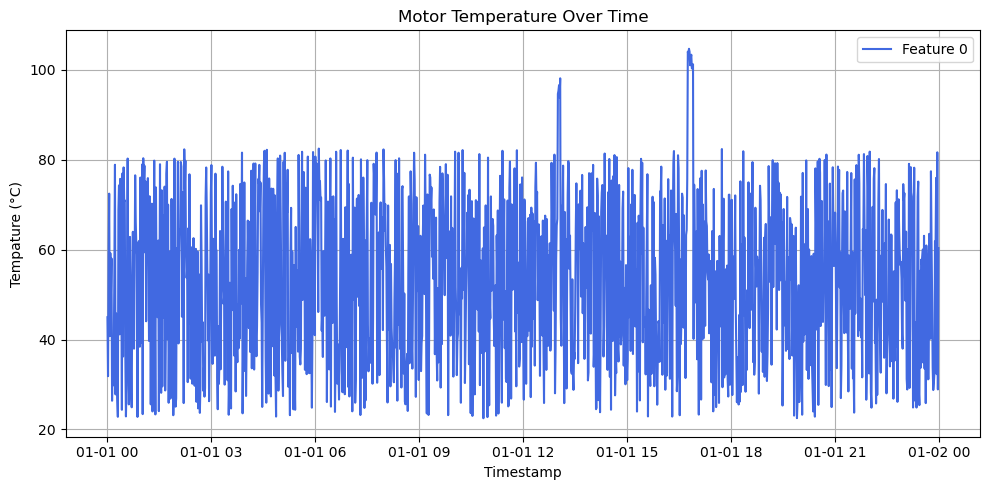

✅ Exported to test_temp.csv


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df['timestamp'].to_numpy(), df['temprature'].to_numpy(), label='Feature 0', color='royalblue')
plt.xlabel("Timestamp")
plt.ylabel("Tempature (°C)")
plt.title("Motor Temperature Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Export to CSV
df.to_csv("test_temp.csv", index=False)

print("✅ Exported to test_temp.csv")